# Evaluate your machine-learning model

In the previous notebook, we check how decision trees and ensemble of trees are working. However, we did not explicitely presented how to evaluate such model once we created it. In this notebook, we aim at presenting how you should evaluate your model. We will first present the benefit of using cross-validation and have a quick look at the different strategies as well as the metrics that should be used in supervised learning.

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Benefit of cross-validation

### Load our dataset

To illustrate our discussion, we will use the California housing dataset. This dataset is a regression problem in which we want to estimate the median housing value given housing information.

In [20]:
from sklearn.datasets import fetch_california_housing

X, y = fetch_california_housing(return_X_y=True, as_frame=True)
y *= 100

In [21]:
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [22]:
y.head()

0    452.6
1    358.5
2    352.1
3    341.3
4    342.2
Name: MedHouseVal, dtype: float64

### Emperical error vs. generalization error

Let's start by creating a regressor which will be a decision tree.

In [23]:
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor()

Let's first train our regressor on the full dataset.

In [24]:
regressor.fit(X, y)

DecisionTreeRegressor()

Now that our regressor is trained, we can check the regressor performance. For this purpose, we will use the mean absolute error which will give us an error in the native unit of the target, i.e. k$.

In [25]:
from sklearn.metrics import mean_absolute_error

y_pred = regressor.predict(X)
score = mean_absolute_error(y_pred, y)
print(f"In average, our regressor make an error of {score:.2f} k$")

In average, our regressor make an error of 0.00 k$


<div class="alert alert-success">
    <b>QUESTION</b>:
     <ul>
     <li>Are you surprised to get such performance with this regressor?</li>
     <li>Do you expect this regressor to perform this way in production?</li>
     </ul>
</div>

Surprisingly or not, our regressor is perfect. However, we are currently not able to confirm if our model would work on future unseen data. We can simulate this stage by splitting out our dataset into two datasets and keep a dataset out of the learning process.

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0
)

In [27]:
regressor.fit(X_train, y_train)

DecisionTreeRegressor()

In [28]:
y_pred = regressor.predict(X_train)
score = mean_absolute_error(y_pred, y_train)
print(f"In average, our regressor make an error of {score:.2f} k$")

In average, our regressor make an error of 0.00 k$


When evaluating our regressor on the training data, we still get a perfect model. This error is called the **emperical error**. Let see, if we get as lucky on the left-out dataset.

In [29]:
y_pred = regressor.predict(X_test)
score = mean_absolute_error(y_pred, y_test)
print(f"In average, our regressor make an error of {score:.2f} k$")

In average, our regressor make an error of 47.62 k$


... and not. By evaluating our model on a left-out set, we are checking that our model will be able to work on unseen data and thus if it is able to generalize. This type of error computed is called **generalization error**. This error is the one that any data scientist hopes to decrease when creating a model.

<div class="alert alert-success">
    <b>QUESTION</b>:
     <ul>
     <li>Are we sure that our algorithm is robust?</li>
     </ul>
</div>

### A single error is not enough, what about the variance?

While we were able to estimate the generalization error, we are indeed unable to know anything about the variance of our model and thus if it is robust our not. This is where the framework of cross-validation is used. Indeed, we can repeat our experiment and compute several time our generalization error and get intuition about the stability of our model.

The simpler way that we can think about is to shuffle our data and split into two sets has we previously did and repeat several time our experiment. In scikit-learn, using the function `cross_validate` with the cross-validation `ShuffleSplit` allows us to make such evaluation.

In [30]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=30, test_size=0.2)

result_cv = cross_validate(
    regressor, X, y, cv=cv, scoring="neg_mean_absolute_error"
)
result_cv

{'fit_time': array([0.25653434, 0.22061229, 0.21470428, 0.23340297, 0.21605444,
        0.23946452, 0.23309898, 0.21374965, 0.22687888, 0.23785329,
        0.23818088, 0.2459867 , 0.23935318, 0.23041964, 0.23680067,
        0.22925091, 0.21750355, 0.25507164, 0.23535633, 0.22441053,
        0.23492241, 0.21971774, 0.23723173, 0.25004768, 0.22821307,
        0.21861601, 0.23305273, 0.2376225 , 0.21999907, 0.23496962]),
 'score_time': array([0.00918937, 0.00421524, 0.00351191, 0.00855494, 0.00368643,
        0.00583339, 0.00355864, 0.00617933, 0.00891781, 0.00814247,
        0.00360084, 0.00499678, 0.00365806, 0.00386477, 0.00326467,
        0.00381494, 0.00415635, 0.0045743 , 0.00350523, 0.00357485,
        0.00479937, 0.00369978, 0.00351238, 0.0038054 , 0.00333071,
        0.00597739, 0.00433946, 0.00585628, 0.00389433, 0.00371337]),
 'test_score': array([-47.24289414, -47.2896984 , -46.22068169, -43.59104942,
        -45.70769307, -46.32508697, -44.24948135, -48.28913905,
        -46.

Once our cross-validation is done, we see that we got a Python dictionary with information regarding the cross-validation. Let's use a pandas dataframe to easily explore the content of the results.

In [31]:
result_cv = pd.DataFrame(result_cv)
result_cv

,fit_time,score_time,test_score
0,0.256534,0.009189,-47.242894
1,0.220612,0.004215,-47.289698
2,0.214704,0.003512,-46.220682
3,0.233403,0.008555,-43.591049
4,0.216054,0.003686,-45.707693
5,0.239465,0.005833,-46.325087
6,0.233099,0.003559,-44.249481
7,0.213750,0.006179,-48.289139
8,0.226879,0.008918,-46.508421
9,0.237853,0.008142,-45.845803


We got information about the training and testing time which we can discard for the moment. However, we see that we got the `test_score` which is our generalization scores. We have 30 numbers because we repeated 30 times the same experiment by shuffling the data. Now, we can plot the distribution of these results.

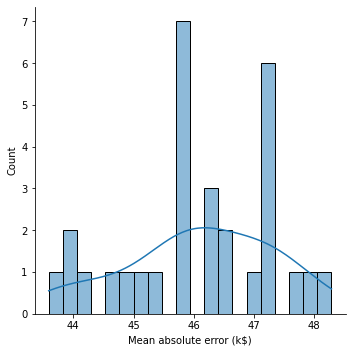

In [32]:
sns.displot(-result_cv["test_score"], kde=True, bins=20)
_ = plt.xlabel("Mean absolute error (k$)")

We can observe that the generalization error is centered around 45.5 k\\$ and range from 44 k\\$ to 47 k\\$.

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
     <li>Can we conclude anything about the performance of our regressor?</li>
     <li>Can we conclude anything about our cross-validation analysis?</li>
     </ul>
    <b>Hint: </b>Plot the distribution of the target.
</div>

To be able to know if we can use our cross-validation results, we should put them into perspective with the problem that we try to solve. To know more about this, we can check the distribution of the original target (which we should have done beforehand).

In [33]:
# %load solutions/solution_1.py

We see that the median value range from 50 k\\$ up to 500 k\\$. Thus an error range of 3 k\\$ means that our cross-validation results can be trusted and do not suffer from an execessive variance. Regarding the performance of our model itself, we can see that making an error of 45 k\\$ would be problematic even more if this happen for housing with low value. However, we also see some limitation regarding the metric that we are using. Making an error of 45 k\\$ for a target at 50 k\\$ and at 500 k\\$ should not have the same impact. We should instead use the mean absolute percentage error which will give a relative error.

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
     <li>Check the distribution of the emperical errors similarly to what we did for the generalization errors.</li>
     <li>What can you conclude?</li>
     </ul>
</div>

What about the emperical error?

In [34]:
# %load solutions/solution_2.py

In [35]:
# %load solutions/solution_3.py

### Effect of the sample size on the variance analysis

We are quite lucky. Our dataset count many samples.

In [36]:
y.size

20640

Let's make an experiment and reduce the number of samples and repeat the previous experiment.

In [37]:
def make_cv_analysis(regressor, X, y):
    cv = ShuffleSplit(n_splits=10, test_size=0.2)
    result_cv = pd.DataFrame(
        cross_validate(
            regressor, X, y, cv=cv, scoring="neg_mean_absolute_error",
            return_train_score=True
        )
    )
    return y.size, (result_cv["test_score"] * -1).values

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
     <li>Make an experiment by subsampling the dataset and plotting the distribution of the generalization errors.</li>
     <li>What can you conclude?</li>
     </ul>
</div>

In [38]:
# %load solutions/solution_4.py
sample_sizes = [100, 500, 1000, 5000, 10000, 15000, y.size]

# TODO

We see that with a low number of samples, the variance is much larger. Indeed, for low number of sample, we cannot even trust our cross-validation and therefore cannot conclude anything about our regressor. Therefore, it is really important to make experiment with a large enough sample size to be sure about the conclusions which would be drawn.

### Comparing results with baseline and chance level

Previously, we compare the generalization error by taking into account the target distribution. A good practice is to compare the generalization error with a dummy baseline and the chance level. In regression, we could use the `DummyRegressor` and predict the mean target without using the data. The chance level can be determined by permuting the labels and check the difference of result.

In [ ]:
from sklearn.dummy import DummyRegressor

dummy = DummyRegressor()
result_dummy = cross_validate(
    dummy, X, y, cv=cv, scoring="neg_mean_absolute_error",
)

In [ ]:
from sklearn.model_selection import permutation_test_score

score, permutation_score, pvalue = permutation_test_score(
    regressor, X, y, cv=cv, scoring="neg_mean_absolute_error",
    n_jobs=-1, n_permutations=30,
)

We plot the generalization errors for each of the experiment. We see that even our regressor does not perform well, it is far above chances our a regressor that would predict the mean target.

In [ ]:
final_result = pd.concat(
    [
        result_cv["test_score"] * -1,
        pd.Series(result_dummy["test_score"]) * -1,
        pd.Series(permutation_score) * -1,
    ], axis=1
).rename(columns={
    "test_score": "Cross-validation score",
    0: "Dummy score",
    1: "Permuted score",
})

In [ ]:
sns.displot(final_result, kind="kde")
_ = plt.xlabel("Mean absolute error (k$)")

## Choice of cross-validation

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
     <li>Does `ShuffleSplit` cross-validation the best cross-validation to use?</li>
     </ul>
</div>

Let's take an example of some financial quotes

In [51]:
import pandas as pd
import os
from urllib.request import urlretrieve

symbols = {'TOT': 'Total', 'XOM': 'Exxon', 'CVX': 'Chevron',
           'COP': 'ConocoPhillips', 'VLO': 'Valero Energy'}

quotes = pd.DataFrame()

for symbol, name in symbols.items():
    url = ('https://raw.githubusercontent.com/scikit-learn/examples-data/'
           'master/financial-data/{}.csv')
    filename = "{}.csv".format(symbol)
    if not os.path.exists(filename):
        urlretrieve(url.format(symbol), filename)
    this_quote = pd.read_csv(filename)
    quotes[name] = this_quote['open']
quotes.index = pd.to_datetime(this_quote['date'])

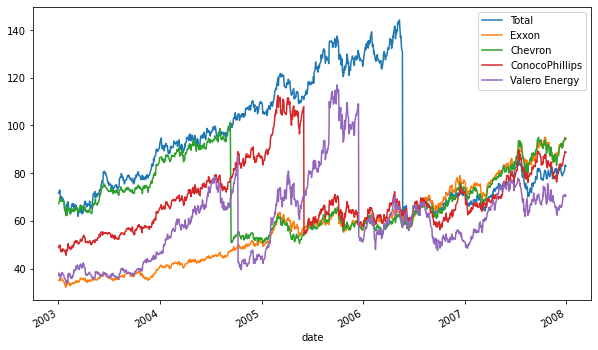

In [52]:
_, ax = plt.subplots(figsize=(10, 6))
_ = quotes.plot(ax=ax)

In [77]:
from sklearn.ensemble import GradientBoostingRegressor

X, y = quotes.drop(columns=["Chevron"]), quotes["Chevron"]
regressor = GradientBoostingRegressor()

In [78]:
cv = ShuffleSplit(n_splits=30)
result_cv = pd.DataFrame(
    cross_validate(
        regressor, X, y, cv=cv,
    )
)
print(f'Mean R2: {result_cv["test_score"].mean():.2f}')

Mean R2: 0.97


<div class="alert alert-success">
    <b>QUESTION</b>:
     It seems that we have the perfect regressor. Is this normal?
</div>

In [80]:
# %load solutions/solution_5.py

Let's check 